# Pharmacokinetics and Pharmacodynamics of Myelotoxicity

### Contents
- [Introduction](1_introduction.ipynb)
- [The Forward Model](2_forward_model.ipynb)
- [Exploring Data](3_data_explore.ipynb)
- [Parameter Inference](4_parameter_inference.ipynb)
- [Parameter Identifiability](5_profile_likelihoods.ipynb)
- [Model Selection](6_PD_naive_pooled_inference.ipynb)
- **Conclusion**
    - [Maximum Likelihood](#Maximum-Likelihood)

In [9]:
import pandas as pd
import pints
import pints.plot
import pints.io
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy import optimize, interpolate, integrate
from Code.PK_model import PintsPKLinIV as Pints_PK_model
from Code.PD_model import PintsPDFribergLinE as Pints_PD_model
from Code.Likelihoods import MultiplicativeGaussianLogLikelihood, GaussianLogLikelihood, ConstantAndMultiplicativeGaussianLogLikelihood

image_file = "../Images/conclusion/"
drug = 'Docetaxel'
num_PK_comp = 2
observation_name = 'Platelets '

## Conclusion

In [10]:
df = pd.read_csv("../Data_and_parameters/PD_real/data_refined_"+drug+"_"+observation_name+".csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
print(df)

unit = "10^3/mcL"
df = df.astype({'OBS': 'float64'})

# Get actual dose amount
patient_info = pd.read_csv("../Data_and_parameters/patient_details_refined_Docetaxel.csv")
patient_info = patient_info.loc[patient_info['ID'].isin(df.ID)].sort_values('ID', ignore_index=True)
# print(patient_info)
dose_amount = patient_info.AMT.mean() # mg
dose_unit = "mg"
print("Average dose amount = " + str(dose_amount))

       ID  DOSE   TIME     OBS
0    5061   0.0  -48.0   937.0
1    5061   0.0   24.0   833.0
2    5061   0.0   96.0  1156.0
3    5061   0.0  168.0  1068.0
4    5061   0.0  240.0  1136.0
..    ...   ...    ...     ...
350  5144  10.0  216.0   909.0
351  5144  10.0  288.0   721.0
352  5144  10.0  360.0  1277.0
353  5144  10.0  480.0   912.0
354  5144  10.0  552.0  1398.0

[355 rows x 4 columns]
Average dose amount = 1.519125


In [11]:
PK_params = np.load('../Data_and_parameters/PK_real/opt_'+str(drug)+'.npy')
PK_param_names = np.load("../Data_and_parameters/PK_sim/actual_params.npy")[0, :]
PD_param_names = np.load("../Data_and_parameters/PD_sim/actual_params.npy")[0, :]

PD_model = Pints_PD_model(PK_params[:-1], data=df, patient_info=patient_info, num_comp=2)

In [12]:
opt_df = pd.read_csv("../Data_and_parameters/PD_real/"+drug+"_opt_results.csv")
opt_add = np.asarray(opt_df['Constant Noise'][0:5])
opt_add_df = pd.DataFrame(data=opt_add.reshape(1,5), columns = PD_param_names[:5])
opt_add_df

,$R_0$,$MTT$,$\gamma$,$S$,"$\sigma_{c, PD}$"
0,989.964402,87.650176,0.472429,15.025145,193.766352


In [13]:
# comparison = np.zeros((len(df), 2))
sim_data = pd.DataFrame(columns=['DOSE', 'TIME', 'sim_OBS'])
for dose in patient_info['DOSE'].unique():
    dose_amt = patient_info.loc[patient_info['DOSE']==dose]["AMT"].values[0]
    sim_obs = PD_model.single_simulate(opt_add[:4], PD_model._times, dose_amt)
    new_rows = pd.DataFrame({'DOSE': [dose]*len(sim_obs), 'TIME': PD_model._times, 'sim_OBS': sim_obs})
    sim_data = pd.concat([sim_data, new_rows], ignore_index=True)
comparison = df.merge(sim_data, on=['DOSE', 'TIME'], how='left')
comparison

,ID,DOSE,TIME,OBS,sim_OBS
0,5061,0.0,-48.0,937.0,989.964402
1,5061,0.0,24.0,833.0,989.964402
2,5061,0.0,96.0,1156.0,989.964402
3,5061,0.0,168.0,1068.0,989.964402
4,5061,0.0,240.0,1136.0,989.964402
...,...,...,...,...,...
350,5144,10.0,216.0,909.0,992.454641
351,5144,10.0,288.0,721.0,1302.022925
352,5144,10.0,360.0,1277.0,1162.550859
353,5144,10.0,480.0,912.0,789.794318


In [14]:
fig = fig = px.scatter(
    comparison,
    x='sim_OBS',
    y='OBS',
    width=400, 
    height=400,
    trendline="lowess",
    trendline_color_override='black',
    color_discrete_sequence=px.colors.qualitative.Plotly[5:],
    hover_data=list(comparison.columns)
)
fig.update_traces(
    marker=dict(opacity=0.6, size=5, symbol="x"),
)
# fig.update_layout(
#     xaxis_title='Predicted Platelet'
# )
axes_range = [0, np.max((comparison['sim_OBS'].max(), comparison['OBS'].max()))*1.02]
fig.add_trace(
    go.Scatter(
        x=axes_range,
        y=axes_range,
        showlegend= False,
        name="",
        marker = dict(color='DarkSlateGrey'),
        mode='lines',
        line_dash="dash",
    ), 
)
fig.update_xaxes(title_text='Predicted Platelet Count, 10^3/ \muL', range=axes_range)
fig.update_yaxes(title_text='Observed Platelet Count, 10^3/ \muL', range=axes_range)
# fig.write_image(image_file + drug + "goodness_of_fit.svg")
fig

In [15]:
num_points = 100
nadir, AUB = PD_model.nadir(opt_add[:4], 0.2*95.38390094909722, num_eval=num_points)

Normal Levels of platelets : 450,000 – 150,000 /μL

Grade 1 Thrombocytopeania : 150,000/μL – 75,000/μL

Grade 2 Thrombocytopeania : 75,000 – 50,000/μL

Grade 3 Thrombocytopeania : 50,000 – 25,000/μL

Grade 4 Thrombocytopeania : <25,000/μL

In [16]:
dose_amts = df.DOSE.unique()
x_label = drug+" Dose, mg/Kg"
unit = " 10^3/ \muL"
y_label = observation_name+ " fraction at Nadir"

# If we assume a base platelet level of 282,000/μL in people
ratio = opt_add[0]/282
thromb_levels = [150*ratio, 75*ratio, 50*ratio, 25*ratio]

df_graph = pd.DataFrame({
    x_label : nadir[0]/0.2,
    y_label : nadir[1]
})

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_graph[x_label],
        y= [thromb_levels[3]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[6]),
        fill='tozeroy',
        mode='lines+text',
        text=[""]*int((num_points-1)/2)+["Grade 4 Thrombocytopeania"]+[""]*(num_points-int((num_points-1)/2)-1),
        textposition="bottom center"
    ), 
)
fig.add_trace(
    go.Scatter(
        x=df_graph[x_label],
        y= [thromb_levels[2]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[5]),
        fill='tonexty',
        mode='lines+text',
        text=[""]*int((num_points-1)/2)+["Grade 3 Thrombocytopeania"]+[""]*(num_points-int((num_points-1)/2)-1),
        textposition="bottom center"
    ), 
)
fig.add_trace(
    go.Scatter(
        x=df_graph[x_label],
        y= [thromb_levels[1]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[4]),
        fill='tonexty',
        mode='lines+text',
        text=[""]*int((num_points-1)/2)+["Grade 2 Thrombocytopeania"]+[""]*(num_points-int((num_points-1)/2)-1),
        textposition="bottom center"
    ), 
)
fig.add_trace(
    go.Scatter(
        x=df_graph[x_label],
        y= [thromb_levels[0]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[3]),
        fill='tonexty',
        mode='lines+text',
        text=[""]*int((num_points-1)/2)+["Grade 1 Thrombocytopeania"]+[""]*(num_points-int((num_points-1)/2)-1),
        textposition="bottom center"
    ), 
)

fig.add_trace(
    go.Scatter(
        x=df_graph[x_label],
        y=df_graph[y_label],
        showlegend= False,
        marker = dict(color=px.colors.qualitative.Plotly[0]),
        mode='lines',
    ), 
)

def Thrombocytopeania(dose, level):
    single_nadir = PD_model.single_nadir(opt_add[:4], dose[0])[0]
    return single_nadir-level

for i, level in enumerate(thromb_levels):
    thromb_point = optimize.root(Thrombocytopeania, 15*0.2, args=(level)).x
    print(
        "Grade "+str(i+1)+" Thrombocytopeania ("+observation_name+ " of "+str(level)+
        ") occurs at a "+drug+" dose of " + str(thromb_point[0]/0.2) + " mg/Kg")
    if thromb_point[0]/0.2<95.38390094909722:
        fig.add_vline(x=thromb_point[0]/0.2, line_dash="dash", line_color=px.colors.sequential.YlOrBr[i+3])
        
fig.update_layout(
    xaxis_title=x_label,
    yaxis_title=y_label,
)        
fig

Grade 1 Thrombocytopeania (Platelets  of 526.576809357541) occurs at a Docetaxel dose of 19.077533239722655 mg/Kg
Grade 2 Thrombocytopeania (Platelets  of 263.2884046787705) occurs at a Docetaxel dose of 43.186344039221716 mg/Kg
Grade 3 Thrombocytopeania (Platelets  of 175.52560311918035) occurs at a Docetaxel dose of 59.78081862141353 mg/Kg
Grade 4 Thrombocytopeania (Platelets  of 87.76280155959017) occurs at a Docetaxel dose of 95.38390094909722 mg/Kg


In [17]:
approx_AUB = np.zeros((len(patient_info), 3))
for i, patient in enumerate(patient_info['ID']):
    dose = patient_info['DOSE'][i]
    time_course = df.loc[df['ID']==patient].sort_values('TIME', ignore_index=True)
    baseline = time_course['OBS'][0]
    below_base = np.asarray(baseline-time_course['OBS'])<0
    approx_AUB[i, 0] = patient
    approx_AUB[i, 1] = dose
    if any(below_base):
        return_to_base = np.argwhere(below_base)[0, 0]
        approx_AUB[i, 2] = integrate.trapezoid(
            time_course['OBS'][:return_to_base], x=time_course['TIME'][:return_to_base]
        )
    else: 
        approx_AUB[i, 2]=0
df_approx_AUB = pd.DataFrame(data=approx_AUB, columns =['ID', 'DOSE', 'AUB'])

In [18]:
dose_amts = df.DOSE.unique()
x_label = drug+" Dose, mg/Kg"
unit = " 10^3$/L"
y_label = "Area under Baseline"

# If we assume a base platelet level of 282,000/μL in people
# thromb_levels = [150/282, 75/282, 50/282, 25/282]

df_graph = pd.DataFrame({
    x_label : AUB[0]/0.2,
    y_label : AUB[1]
})

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_graph[x_label],
        y=df_graph[y_label],
        showlegend= False,
        marker = dict(color=px.colors.qualitative.Plotly[0]),
        mode='lines',
    ), 
)
        
fig.update_layout(
    xaxis_title=x_label,
    yaxis_title=y_label,
)        
fig

In [19]:
samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_add_samples_chain', n=3))
num_samples = int(0.7*7*2500)
mean_sample = np.vstack(samples[:,-num_samples:]).mean(axis=0)
print(mean_sample)

[9.87626803e+02 8.69606609e+01 4.54511342e-01 1.92648058e+01
 1.67733402e+02]


In [20]:
timer = pints.Timer()
samples_nadir = np.zeros((int(np.ceil(num_samples)*3/10), num_points))
for i, sample in enumerate(np.vstack(samples[:,-num_samples::10])):
    time_stamp = timer.time()
    frac_done = i/int(np.ceil(num_samples)*3/10)
    print(
        "\r" + str(np.round(frac_done*100, 2)) +
        "% complete," + " time elapsed: " +
        timer.format(time_stamp),
        sep=' ',
        end='        ',
        flush=True
    )
    nadir_i = PD_model.nadir(sample[:4], 0.2*95.38390094909722, num_eval=num_points)[0]
    samples_nadir[i, :] = nadir_i[1]

0.44% complete, time elapsed: 59.67 seconds        seconds        

KeyboardInterrupt: 

In [ ]:
# nadir_fraction = samples_nadir/np.hstack(samples[:,-num_samples::10,0]).reshape(-1,1)

In [ ]:
# np.save('../Data_and_parameters/nadir', samples_nadir)

In [21]:
doses = np.linspace(0, 95.38390094909722, num_points)

samples_nadir = np.load('../Data_and_parameters/nadir.npy')
mean_nadir = PD_model.nadir(mean_sample[:4], 0.2*95.38390094909722, num_eval=num_points)[0]
mean_nadir = mean_nadir[1]
dose_amts = df.DOSE.unique()
x_label = drug+" Dose, mg/Kg"
unit = " 10^3$/L"
y_label = observation_name+ " count at Nadir"

# If we assume a base platelet level of 282,000/μL in people
ratio = opt_add[0]/282
thromb_levels = [150*ratio, 75*ratio, 50*ratio, 25*ratio]

# df_graph = pd.DataFrame(data = {
#     x_label : nadir[0]/0.2,
#     y_label : nadir[1]/opt_add[0]
# })

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=doses,
        y= [thromb_levels[3]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[6]),
        fill='tozeroy',
        mode='lines+text',
        name="Grade 4 Thrombocytopeania",
        text=["Grade 4"]+[""]*int((num_points-1)/2)+[""]*(num_points-int((num_points-1)/2)-1),
        textposition="bottom right"
    ), 
)
fig.add_trace(
    go.Scatter(
        x=doses,
        y= [thromb_levels[2]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[5]),
        fill='tonexty',
        mode='lines+text',
        name="Grade 3 Thrombocytopeania",
        text=["Grade 3"]+[""]*int((num_points-1)/2)+[""]*(num_points-int((num_points-1)/2)-1),
        textposition="bottom right"
    ), 
)
fig.add_trace(
    go.Scatter(
        x=doses,
        y= [thromb_levels[1]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[4]),
        fill='tonexty',
        mode='lines+text',
        name="Grade 2 Thrombocytopeania",
        text=[""]*int((num_points-1)/2)+[""]*(num_points-int((num_points-1)/2)-1)+["Grade 2"],
        textposition="bottom left"
    ), 
)
fig.add_trace(
    go.Scatter(
        x=doses,
        y= [thromb_levels[0]]*num_points,
        showlegend= False,
        marker = dict(color=px.colors.sequential.YlOrBr[3]),
        fill='tonexty',
        mode='lines+text',
        name="Grade 1 Thrombocytopeania",
        text=[""]*int((num_points-1)/2)+[""]*(num_points-int((num_points-1)/2)-1)+["Grade 1"],
        textposition="bottom left"
    ), 
)

min_nadir = samples_nadir.min(axis=0)
fig.add_trace(
    go.Scatter(
        x=doses,
        y=min_nadir,
        showlegend= False,
        marker = dict(color=px.colors.qualitative.Plotly[5]),
        mode='lines',
    ), 
)
max_nadir = samples_nadir.max(axis=0)
fig.add_trace(
    go.Scatter(
        x=doses,
        y=max_nadir,
        showlegend=True,
        name="Range of samples",
        fill='tonexty',
        marker = dict(color=px.colors.qualitative.Plotly[5]),
        mode='lines',
    ), 
)
# mean_nadir = samples_nadir.mean(axis=0)
fig.add_trace(
    go.Scatter(
        x=doses,
        y=mean_nadir,
        showlegend= True,
        name="Mean of samples",
        marker = dict(color=px.colors.qualitative.Plotly[0]),
        mode='lines',
    ), 
)


fig.add_trace(
    go.Scatter(
        x=nadir[0]/0.2,
        y=nadir[1],
        showlegend= True,
        name="Maximum Likelihood estimate",
        marker = dict(color=px.colors.qualitative.Plotly[0]),
        mode='lines', 
        line_dash="dash",
    ), 
)

for i, level in enumerate(thromb_levels):
    thromb_point = interpolate.CubicSpline(doses, min_nadir-level).roots()
    if thromb_point[0]<95.38390094909722:
        print(
            "Grade "+str(i+1)+" Thrombocytopeania ("+observation_name+ " count of "+str(level)+
            ") occurs at a "+drug+" dose of " + str(thromb_point[0]) + " mg/Kg")
        fig.add_vline(
            x=thromb_point[0], 
            line_dash="dash", 
            line_color=px.colors.sequential.YlOrBr[i+3],
            annotation_text="Grade "+ str(i+1) + ": " +str(np.round(thromb_point[0], 1)), 
            annotation_position="top right"
        )

fig.update_layout(
    width=650,
    height=400,
)
fig.update_yaxes(title_text=y_label, range=[0,1000])
fig.update_xaxes(title_text=x_label)
# fig.write_image(image_file + drug + "dose_comparison.svg")
fig

Grade 1 Thrombocytopeania (Platelets  count of 526.576809357541) occurs at a Docetaxel dose of 11.541613452952816 mg/Kg
Grade 2 Thrombocytopeania (Platelets  count of 263.2884046787705) occurs at a Docetaxel dose of 25.705578260312365 mg/Kg
Grade 3 Thrombocytopeania (Platelets  count of 175.52560311918035) occurs at a Docetaxel dose of 34.97386567327734 mg/Kg
Grade 4 Thrombocytopeania (Platelets  count of 87.76280155959017) occurs at a Docetaxel dose of 53.534092760538535 mg/Kg


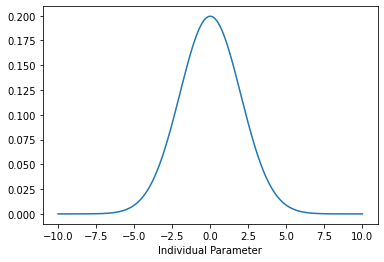

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-10, 10, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0,2))
plt.xlabel("Individual Parameter")

# plt.savefig("normal_dist_ind.svg")
plt.show()